In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [35]:
CITIES = 30
POPULATION_SIZE = 100
GENERATIONS = 600
CROSS_PROB = 0.85
MUT_PTOB = 0.1
SELECTION_SIZE = 10

In [36]:
# generowanie miast
def generate_cities(number_of_cities, max_value=100):
    # ziarno, zeby wyniki byly takie same
    np.random.seed(20)
    x = np.random.randint(low=0, high=max_value, size=number_of_cities)
    y = np.random.randint(low=0, high=max_value, size=number_of_cities)
    return np.column_stack((x,y))

In [37]:
# obliczanie odleglosci miedzy punktami
def calculate_distance(city_1, city_2):
    return np.sqrt((city_1[0] - city_2[0])**2 + (city_1[1] - city_2[1])**2)

In [38]:
# macierz odleglosci wzajemnych
def distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i, j] = calculate_distance(cities[i], cities[j])
            else:
                dist_matrix[i, j] = 0
    return dist_matrix

In [39]:
# generacja populacji
def generate_population(pop_size, num_of_cities):
    population = []
    for _ in range(pop_size):
        population.append(np.random.permutation(num_of_cities))
    return population

In [40]:
# funkcja przystosowania dla danego osobnika
def total_distance(chromosome, dist_matrix):
    distance = 0
    for i in range(len(chromosome) - 1):
        distance += dist_matrix[chromosome[i], chromosome[i+1]]
    distance += dist_matrix[chromosome[-1], chromosome[0]]
    return distance

In [41]:
# sortowanie populacji
def sort_population(population, dist_matrix):
    return sorted(population, key = lambda x: total_distance(x, dist_matrix))

In [42]:
# selekcja
def selection(sorted_population, selection_size):
    return sorted_population[:selection_size]

In [43]:
# parent1 i parent2 to juz są pojedyncze osobniki, które stają się rodzicami
def crossover(parent_1, parent_2):
    size = len(parent_1)
    # losuje losowy index osobnika, ktory bedzie podlegal krzyzowaniu
    start, end = sorted(np.random.choice(a=size, size=2, replace=False))
    
    # inicjalizuje sobie puste dzieci
    child_1 = -np.ones(size, dtype=int)
    child_2 = -np.ones(size, dtype=int)
    
    # przypisuje dziecom skrzyzowane punkty rodzica w wycinku
    child_1[start:end+1] = parent_2[start:end+1]
    child_2[start:end+1] = parent_1[start:end+1]
    
    
    # dopisuje reszte tak, zeby nie bylo powtorek
    def fill_child(child, donor_parent, segment_parent):
        for i in range(size):
            if i < start or i > end:
                candidate = donor_parent[i]
                while candidate in child:
                    # Znajdź odpowiednik w drugim rodzicu
                    pos = np.where(segment_parent == candidate)[0][0]
                    candidate = donor_parent[pos]
                child[i] = candidate
                
                
    fill_child(child_1, parent_2, parent_1)
    fill_child(child_2, parent_1, parent_2)
    
    return child_1, child_2

In [44]:
# mutacja
def mutation(chromosome):
    size = len(chromosome)
    first, second = np.random.choice(a=size, size=2, replace=False)
    chromosome[first], chromosome[second] = chromosome[second], chromosome[first]
    return chromosome

In [45]:
# algorytm genetyczny
def genetic_algorithm(num_of_cities, population_size, num_of_generations, selection_size, crossover_prob, mutation_prob):
    cities = generate_cities(num_of_cities)
    population = generate_population(population_size, num_of_cities)
    dist_matrix = distance_matrix(cities)
    
    best_distances = []
    mean_distances = []
    worst_distances = []
    best_individuals = []
    
    # glowna petla
    for generation in range(num_of_generations):
        sorted_population = sort_population(population, dist_matrix)
        new_population = selection(sorted_population, selection_size)
        # uzupelniam reszte populacji
        while len(new_population) < population_size:
            if np.random.random() <= crossover_prob:
                parent_1, parent_2 = random.sample(sorted_population, 2)
                child_1, child_2 = crossover(parent_1, parent_2)
                new_population.append(child_1)
                if len(new_population) < population_size:
                    new_population.append(child_2)
            if np.random.random() <= mutation_prob and len(new_population) < population_size:
                chromosome = random.choice(sorted_population)
                new_chromosome = mutation(chromosome)
                new_population.append(new_chromosome)
        population = sort_population(new_population, dist_matrix)
        distances = [total_distance(chromosome, dist_matrix) for chromosome in population]
        best_dist = np.min(distances)
        best_distances.append(best_dist)
        
        worst_dist = np.max(distances)
        worst_distances.append(worst_dist)
        
        mean_dist = np.mean(distances)
        mean_distances.append(mean_dist)
        
        best_idx = np.argmin(distances)
        best_individuals.append(population[best_idx])
        
        if generation % 50 == 0:
            print(f'Population number {generation}, best distance = {best_dist}')
    return best_distances, worst_distances, mean_distances, best_individuals, cities

In [46]:
start = time.time()
best_distances, worst_distances, mean_distances, best_individuals, cities = genetic_algorithm(CITIES, POPULATION_SIZE,
                                                                                      GENERATIONS, SELECTION_SIZE, CROSS_PROB, MUT_PTOB)
end = time.time()
print(f'Genetic Algorithm took: {end - start} seconds')

Population number 0, best distance = 1369.9400762834737
Population number 50, best distance = 1090.7962298351626
Population number 100, best distance = 987.6164920203681
Population number 150, best distance = 894.4841133425391
Population number 200, best distance = 857.2137886969815
Population number 250, best distance = 785.9376917116313
Population number 300, best distance = 722.3190374405388
Population number 350, best distance = 698.4735775434565
Population number 400, best distance = 675.1120966959156
Population number 450, best distance = 675.1120966959156
Population number 500, best distance = 670.1724940735571
Population number 550, best distance = 669.8334304871585
Genetic Algorithm took: 7.20639705657959 seconds


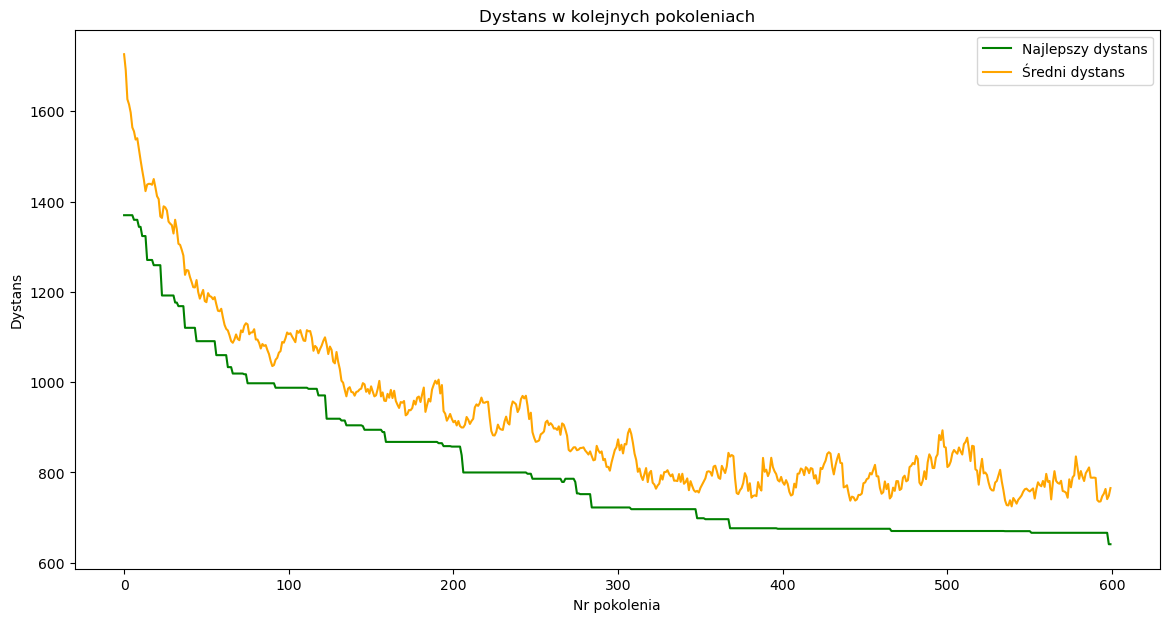

In [48]:
fig = plt.figure(figsize=(14,7))
plt.plot(best_distances, color='green', label='Najlepszy dystans')
plt.plot(mean_distances, color='orange', label='Średni dystans')
plt.xlabel('Nr pokolenia')
plt.ylabel('Dystans')
plt.title('Dystans w kolejnych pokoleniach')
plt.legend()
fig.show()